# CDFS SWIRE master catalogue
## Preparation of COMBO data

Classifying Objects by Medium-Band Observations - a spectrophotometric 17-filter survey (COMBO-17). COMBO catalogue: the catalogue comes from `dmu0_COMBO-17`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The total magnitude (aperture magnitudes are not provided.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
91cdb7b (Fri Oct 20 11:48:11 2017 +0100)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy import constants as const
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import nb_astcor_diag_plot, remove_duplicates
from herschelhelp_internal.utils import astrometric_correction, mag_to_flux, flux_to_mag


In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "combo_ra"
DEC_COL = "combo_dec"

## I - Column selection

In [4]:
imported_columns = OrderedDict({
    'Seq':'combo_id', 
    'ra':'combo_ra', 
    'dec':'combo_dec',  
    #'dl':'combo_dl',
    'stellarity':'combo_stellarity',
    'Rmag':'m_combo_r',    #The catalogue is R selected
    'e_Rmag':'merr_combo_r',  
    #'Ap_Rmag':'m_ap_combo_r',
    #'UjMag':'m_combo_uj',   #These bands are derived absolute magnitudes
    #'e_UjMag':'merr_combo_uj', 
    #'BjMag':'m_combo_bj',   
    #'e_BjMag':'merr_combo_bj',
    #'VjMag':'m_combo_vj',   
    #'e_VjMag':'merr_combo_vj',
    #'usMag':'m_combo_us',   
    #'e_usMag':'merr_combo_us',
    #'gsMag':'m_combo_gs',   
    #'e_gsMag':'merr_combo_gs',
    #'rsMag':'m_combo_rs',   
    #'e_rsMag':'merr_combo_rs',
    #'UbMag':'m_combo_ub',   
    #'e_UbMag':'merr_combo_ub',
    #'BbMag':'m_combo_bb',   
    #'e_BbMag':'merr_combo_bb',
    #'VbMag':'m_combo_vb',   
    #'e_VbMag':'merr_combo_vb',
    #'S280Mag':'m_combo_s280', 
    #'e_S280Mag':'merr_combo_s280',
    ##'S145Mag':'m_combo_s145', 
    #'e_S145Mag':'merr_combo_s145',
    'W420F_E':'f_ap_combo_420', #The following values are given as fluxes
    'e_W420F_E':'ferr_ap_combo_420',
    'W462F_E':'f_ap_combo_462',
    'e_W462F_E':'ferr_ap_combo_462',
    'W485F_D':'f_ap_combo_485',
    'e_W485F_D':'ferr_ap_combo_485',
    'W518F_E':'f_ap_combo_518',
    'e_W518F_E':'ferr_ap_combo_518',
    'W571F_S':'f_ap_combo_571',   #Combined flux from two runs
    'e_W571F_S':'ferr_ap_combo_571',
    'W604F_E':'f_ap_combo_604',
    'e_W604F_E':'ferr_ap_combo_604',
    'W646F_D':'f_ap_combo_646',
    'e_W646F_D':'ferr_ap_combo_646',
    'W696F_E':'f_ap_combo_696',
    'e_W696F_E':'ferr_ap_combo_696',
    'W753F_E':'f_ap_combo_753',
    'e_W753F_E':'ferr_ap_combo_753',
    'W815F_S':'f_ap_combo_815',
    'e_W815F_S':'ferr_ap_combo_815',
    'W856F_D':'f_ap_combo_856',
    'e_W856F_D':'ferr_ap_combo_856',
    'W914F_D':'f_ap_combo_914', #Two runs but no combined - taking first
    'e_W914F_D':'ferr_ap_combo_914',
    'UF_S':'f_ap_combo_u',
    'e_UF_S':'ferr_ap_combo_u',
    'BF_S':'f_ap_combo_b',
    'e_BF_S':'ferr_ap_combo_b',
    'VF_D':'f_ap_combo_v',
    'e_VF_D':'ferr_ap_combo_v',
    'RF_S':'f_ap_combo_r',
    'e_RF_S':'ferr_ap_combo_r',
    'IF_D':'f_ap_combo_i',
    'e_IF_D':'ferr_ap_combo_i'
    })

catalogue = Table.read("../../dmu0/dmu0_COMBO-17/data/table3.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2000 #table says 1999 to 2001

# Clean table metadata
catalogue.meta = None

In [5]:
catalogue[:10].show_in_notebook()

idx,combo_id,combo_ra,combo_dec,combo_stellarity,m_combo_r,merr_combo_r,f_ap_combo_420,ferr_ap_combo_420,f_ap_combo_462,ferr_ap_combo_462,f_ap_combo_485,ferr_ap_combo_485,f_ap_combo_518,ferr_ap_combo_518,f_ap_combo_571,ferr_ap_combo_571,f_ap_combo_604,ferr_ap_combo_604,f_ap_combo_646,ferr_ap_combo_646,f_ap_combo_696,ferr_ap_combo_696,f_ap_combo_753,ferr_ap_combo_753,f_ap_combo_815,ferr_ap_combo_815,f_ap_combo_856,ferr_ap_combo_856,f_ap_combo_914,ferr_ap_combo_914,f_ap_combo_u,ferr_ap_combo_u,f_ap_combo_b,ferr_ap_combo_b,f_ap_combo_v,ferr_ap_combo_v,f_ap_combo_r,ferr_ap_combo_r,f_ap_combo_i,ferr_ap_combo_i
,,,,,mag,mag,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm,phot/m^2/s/nm
0,1,53.0465526019,-28.0648239803,nan,25.898,0.2597,0.00264355,0.00285258,0.00194419,0.00507824,0.00634075,0.00330823,0.0128999,0.00558538,0.00422165,0.00358899,0.00545072,0.0037928,-0.00246295,0.0111153,0.0036688,0.0029749,-0.00616114,0.00518921,0.0052579,0.00298374,0.0138997,0.00716615,-0.0125596,0.00860921,0.0125756,0.00217833,0.00852939,0.000966432,0.00475216,0.00165534,0.00454238,0.000565242,0.00718207,0.00517013
1,2,52.939626246,-28.0646283765,nan,25.9228,0.1994,0.00497259,0.00332512,0.00539682,0.00283857,0.0148293,0.00613066,0.00821942,0.00386862,0.0104317,0.00433921,0.0114887,0.00519873,0.00774973,0.00812507,0.00627177,0.00393549,0.01143,0.00659333,0.00841453,0.00455059,0.0222515,0.00914342,0.00279212,0.0074647,0.00972669,0.00226972,0.00416631,0.00116023,0.00417219,0.0021428,0.00639536,0.000584555,0.0124295,0.00564517
2,3,53.2521450063,-28.0651043505,nan,26.0809,0.2214,0.00293746,0.00424515,-0.00497165,0.00642635,0.00559756,0.00528361,0.00512862,0.00436576,0.00120117,0.00398801,0.0116348,0.00397886,-0.0103009,0.0161689,0.000793298,0.0042021,0.00217922,0.00769792,-0.00609948,0.0044404,-0.0118984,0.0135821,0.0207912,0.0141984,-0.00178639,0.00348119,-1.93626e-05,0.00197834,0.00322432,0.00175771,-0.000330044,0.00080327,-0.0143755,0.0109746
3,4,53.3679577582,-28.0651779258,nan,24.8736,0.1563,0.00639214,0.00259626,0.00563183,0.00358235,0.00563781,0.00441638,0.00685228,0.00484382,0.00269856,0.00369291,0.0116411,0.00398695,0.0310949,0.0130368,0.0102668,0.00299234,0.0114095,0.00507012,0.0115176,0.00347368,0.0239881,0.00872553,0.00426008,0.00673841,0.00568031,0.00189686,0.00411945,0.00119282,0.00671227,0.00176432,0.0115915,0.000482617,0.0070293,0.00413979
4,5,53.3210626453,-28.0651334757,nan,25.7842,0.2698,0.00252849,0.00265029,0.004257,0.00383994,0.00244114,0.00493029,0.00787371,0.00352079,0.00461165,0.00320873,0.00396578,0.00512525,-0.0162174,0.00684174,0.00375587,0.00333458,0.0151917,0.00524281,0.00791889,0.00304835,0.0194158,0.00747347,0.000609587,0.0062265,-0.000130933,0.00210749,0.00352178,0.00106931,0.00208002,0.00139866,0.00313952,0.00058712,-8.12998e-05,0.00389229
5,6,53.2920972875,-28.0651280661,nan,24.995,0.0972,0.0199486,0.00371804,0.0130156,0.0038131,0.0182201,0.00433024,0.0175872,0.00342212,0.0151289,0.00309924,0.0177775,0.00436562,0.0191804,0.00574883,0.0265296,0.00377887,0.0266321,0.00570456,0.0237083,0.0029196,0.0279242,0.00624807,0.0430727,0.00696083,0.0212855,0.00273096,0.0156904,0.00124653,0.0172505,0.00140405,0.0173493,0.000455714,0.0276486,0.00540542
6,7,53.2299678259,-28.0650300589,nan,25.8715,0.2882,0.00120451,0.00389763,0.00441325,0.00279763,0.00458269,0.00554616,0.00987573,0.00396222,0.00678149,0.00331607,0.00478133,0.00521684,0.0155447,0.015445,0.00583351,0.00292556,0.0163552,0.0060355,0.00601305,0.00428294,0.0074658,0.00770433,0.0190866,0.00732659,-0.000848918,0.00261226,0.00382357,0.00129182,0.00565541,0.00258135,0.00347

## Unit conversion

### Using mid wavelength
The flux is presented in $\textrm{photons} .\textrm{s}^{-1} .  \textrm{m}^{-2}  .\textrm{nm}^{-1}$. We wish to convert these to micro Jansky; $10^{-32} \textrm{ W} . \textrm{m}^{-2}  . \textrm{Hz}^{-1} $.

To convert $\textrm{photons} . \textrm{s}^{-1} $ to $\textrm{W}$ we must multiply by the average photon energy $h c / \lambda$. We presume that the COMBO mid point wavelength was used.

To convert $\textrm{nm}^{-1}$ to $\textrm{Hz}^{-1}$ we must differenciate:

$c = \nu \lambda $

$\nu = c / \lambda$

$\frac{d \nu}{d \lambda} = - c /\lambda^{2}$

$d \lambda = -  (\lambda^{2} / c )\times d \nu$



The net result of this is to multiply by $\lambda^2 / c$.

Combining these two unit conversions leads to overall multiplying by $ h \lambda$:

$(\lambda^2 / c ) \times (h c / \lambda) = h \lambda$



In [6]:
#Example conversion from photon s^-1 m^-2 nm^-1 to Jy
flux_lambda = 0.0064185 * (u.m **-2) * (u.s ** -1) *( u.nm ** -1)

wavelength = 420 * u.nm
flux_nu = flux_lambda * const.h *  wavelength
print('flux_lambda:', flux_lambda)
#print('f_lambda:', flux_lambda.decompose())
print('flux_nu:', flux_nu)
print('flux_nu in Jy:',flux_nu.to(u.Jy))


flux_lambda: 0.0064185 1 / (m2 nm s)
flux_nu: 1.78623595647189e-33 J / m2
flux_nu in Jy: 1.7862359564718896e-07 Jy


### Using Vega flux
The paper provides fluxes of Vega in each band allowing conversion to Vega mag. It then provides the difference between Vega mag and AB mag per band to convert to AB. We can therefore calculate the AB magnitude and convert that back to flux to get the flux in Jy.

In [7]:
#Set wavelengths for unit conversion.
#All from http://cds.aanda.org/component/article?access=bibcode&bibcode=2004A%252526A...421..913W
#Wavelengths in the table column headings are marginally different to those in the paper.
#   Band name   \lambda    Vega AB Fphot (Vega 10^8 photons s^-1 m^-2 nm^-1)
wavelengths = {
    'f_ap_combo_420':   [418, -0.19, 1.571], 
    'ferr_ap_combo_420':[418, -0.19, 1.571],
    'f_ap_combo_462':   [462, -0.18, 1.412],
    'ferr_ap_combo_462':[462, -0.18, 1.412],
    'f_ap_combo_485':   [486, -0.06, 1.207], 
    'ferr_ap_combo_485':[486, -0.06, 1.207],
    'f_ap_combo_518':   [519, -0.06, 1.125],
    'ferr_ap_combo_518':[519, -0.06, 1.125],
    'f_ap_combo_571':   [572,  0.04, 0.932],   
    'ferr_ap_combo_571':[572,  0.04, 0.932],
    'f_ap_combo_604':   [605,  0.10, 0.832],
    'ferr_ap_combo_604':[605,  0.10, 0.832],
    'f_ap_combo_646':   [645,  0.22, 0.703], 
    'ferr_ap_combo_646':[645,  0.22, 0.703], 
    'f_ap_combo_696':   [696,  0.27, 0.621],
    'ferr_ap_combo_696':[696,  0.27, 0.621],
    'f_ap_combo_753':   [753,  0.36, 0.525],
    'ferr_ap_combo_753':[753,  0.36, 0.525],
    'f_ap_combo_815':   [816,  0.45, 0.442], 
    'ferr_ap_combo_815':[816,  0.45, 0.442], 
    'f_ap_combo_856':   [857,  0.56, 0.386],  
    'ferr_ap_combo_856':[857,  0.56, 0.386],
    'f_ap_combo_914':   [914,  0.50, 0.380],
    'ferr_ap_combo_914':[914,  0.50, 0.380],
    'f_ap_combo_u':     [365,  0.77, 0.737],
    'ferr_ap_combo_u':  [365,  0.77, 0.737],
    'f_ap_combo_b':     [458, -0.13, 1.371],
    'ferr_ap_combo_b':  [458, -0.13, 1.371],
    'f_ap_combo_v':     [538, -0.02, 1.055],
    'ferr_ap_combo_v':  [538, -0.02, 1.055],
    'f_ap_combo_r':     [648,  0.19, 0.725],
    'ferr_ap_combo_r':  [648,  0.19, 0.725],
    'f_ap_combo_i':     [857,  0.49, 0.412],
    'ferr_ap_combo_i':  [857,  0.49, 0.412]
}



In [8]:
#Example conversion from photon s^-1 m^-2 nm^-1 to Jy
flux_lambda = 0.0064185 #* (u.m **-2) * (u.s ** -1) *( u.nm ** -1)

mag_vega = -2.5 *np.log10(flux_lambda/(wavelengths['f_ap_combo_420'][2]*1.e8))
print(mag_vega)
mag_AB = mag_vega + wavelengths['f_ap_combo_420'][1]
print(mag_AB)
flux_converted = mag_to_flux(mag_AB)
print(flux_converted)
#This is different to the value calculated using mid point wavelength as we expect 
#because it should take account of the filter response better.

25.9718565988
25.7818565988
(1.7670846750466056e-07, None)


In [9]:
#Replace 0.0 with NaN values
for col in catalogue.colnames:
    catalogue[col].unit = None
    if col.startswith('m'): # | col.endswith('ra') | col.endswith('dec'):
        catalogue[col][np.where(catalogue[col] == 0.0)] = np.nan

# Add magnitude, fix flux units and add band-flag columns
nancol = np.zeros(len(catalogue))
nancol.fill(np.nan)
for col in catalogue.colnames:
    if col.startswith('f_'):
         
        errcol = "ferr{}".format(col[1:])
        
        #Replace mask with nan
        catalogue[col].fill_value = np.nan
        catalogue[errcol].fill_value = np.nan
        
        #Calculate magnitudes using Vega fluxes from wavelengths (values from paper)
        magnitude = -2.5*np.log10(catalogue[col].filled()/(wavelengths[col][2]*1.e8)) + wavelengths[col][1]
        magnitude_error = 2.5/np.log(10)*(catalogue[errcol].filled()/catalogue[col].filled() )

        catalogue.add_column(Column(nancol, 
                                    name="m{}".format(col[1:])))
        catalogue.add_column(Column(nancol, 
                                    name="m{}".format(errcol[1:])))
        # Add the AB magnitudes
        catalogue["m{}".format(col[1:])] = magnitude
        catalogue["m{}".format(errcol[1:])] = magnitude_error
    
        flux_new, flux_new_error = mag_to_flux(magnitude, magnitude_error)
        catalogue[col] = flux_new * 1.e6 # uJy
        catalogue[errcol] = flux_new_error * 1.e6 # uJy 
        
        
        #We add NAN filled total columns because no total fluxes are present
        if not col == 'f_ap_combo_r':
            catalogue.add_column(Column(nancol, 
                                    name="m{}".format(col[4:])))
            catalogue.add_column(Column(nancol, 
                                    name="merr{}".format(col[4:])))
            catalogue.add_column(Column(nancol, 
                                    name="f{}".format(col[4:])))
            catalogue.add_column(Column(nancol, 
                                    name="ferr{}".format(col[4:])))
        
        # 
        
        # Band-flag column
        catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), name="flag{}".format(col[4:])))
        
#Add total fluxes for R band
f_combo_r, ferr_combo_r = mag_to_flux(catalogue['m_combo_r'],catalogue['merr_combo_r'])
catalogue['f_combo_r'] = f_combo_r
catalogue['ferr_combo_r'] = ferr_combo_r

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in log10


In [10]:
catalogue[:10].show_in_notebook()

idx,combo_id,combo_ra,combo_dec,combo_stellarity,m_combo_r,merr_combo_r,f_ap_combo_420,ferr_ap_combo_420,f_ap_combo_462,ferr_ap_combo_462,f_ap_combo_485,ferr_ap_combo_485,f_ap_combo_518,ferr_ap_combo_518,f_ap_combo_571,ferr_ap_combo_571,f_ap_combo_604,ferr_ap_combo_604,f_ap_combo_646,ferr_ap_combo_646,f_ap_combo_696,ferr_ap_combo_696,f_ap_combo_753,ferr_ap_combo_753,f_ap_combo_815,ferr_ap_combo_815,f_ap_combo_856,ferr_ap_combo_856,f_ap_combo_914,ferr_ap_combo_914,f_ap_combo_u,ferr_ap_combo_u,f_ap_combo_b,ferr_ap_combo_b,f_ap_combo_v,ferr_ap_combo_v,f_ap_combo_r,ferr_ap_combo_r,f_ap_combo_i,ferr_ap_combo_i,m_ap_combo_420,merr_ap_combo_420,m_combo_420,merr_combo_420,f_combo_420,ferr_combo_420,flag_combo_420,m_ap_combo_462,merr_ap_combo_462,m_combo_462,merr_combo_462,f_combo_462,ferr_combo_462,flag_combo_462,m_ap_combo_485,merr_ap_combo_485,m_combo_485,merr_combo_485,f_combo_485,ferr_combo_485,flag_combo_485,m_ap_combo_518,merr_ap_combo_518,m_combo_518,merr_combo_518,f_combo_518,ferr_combo_518,flag_combo_518,m_ap_combo_571,merr_ap_combo_571,m_combo_571,merr_combo_571,f_combo_571,ferr_combo_571,flag_combo_571,m_ap_combo_604,merr_ap_combo_604,m_combo_604,merr_combo_604,f_combo_604,ferr_combo_604,flag_combo_604,m_ap_combo_646,merr_ap_combo_646,m_combo_646,merr_combo_646,f_combo_646,ferr_combo_646,flag_combo_646,m_ap_combo_696,merr_ap_combo_696,m_combo_696,merr_combo_696,f_combo_696,ferr_combo_696,flag_combo_696,m_ap_combo_753,merr_ap_combo_753,m_combo_753,merr_combo_753,f_combo_753,ferr_combo_753,flag_combo_753,m_ap_combo_815,merr_ap_combo_815,m_combo_815,merr_combo_815,f_combo_815,ferr_combo_815,flag_combo_815,m_ap_combo_856,merr_ap_combo_856,m_combo_856,merr_combo_856,f_combo_856,ferr_combo_856,flag_combo_856,m_ap_combo_914,merr_ap_combo_914,m_combo_914,merr_combo_914,f_combo_914,ferr_combo_914,flag_combo_914,m_ap_combo_u,merr_ap_combo_u,m_combo_u,merr_combo_u,f_combo_u,ferr_combo_u,flag_combo_u,m_ap_combo_b,merr_ap_combo_b,m_combo_b,merr_combo_b,f_combo_b,ferr_combo_b,flag_combo_b,m_ap_combo_v,merr_ap_combo_v,m_combo_v,merr_combo_v,f_combo_v,ferr_combo_v,flag_combo_v,m_ap_combo_r,merr_ap_combo_r,flag_combo_r,m_ap_combo_i,merr_ap_combo_i,m_combo_i,merr_combo_i,f_combo_i,ferr_combo_i,flag_combo_i,f_combo_r,ferr_combo_r
0,1,53.0465526019,-28.0648239803,nan,25.898,0.2597,0.07278,0.0785347,0.0590071,0.154127,0.201573,0.105169,0.439981,0.190502,0.158513,0.134758,0.216935,0.150951,nan,nan,0.167275,0.135638,nan,nan,0.285358,0.161934,0.780581,0.402438,nan,nan,0.304832,0.0528026,0.254613,0.0288491,0.166586,0.0580278,0.190961,0.0237627,0.403044,0.290138,26.745,1.17159,nan,nan,nan,nan,False,26.9727,2.83595,nan,nan,nan,nan,False,25.6389,0.566474,nan,nan,nan,nan,False,24.7914,0.4701,nan,nan,nan,nan,False,25.8998,0.923026,nan,nan,nan,nan,False,25.5592,0.755493,nan,nan,nan,nan,False,nan,-4.89994,nan,nan,nan,nan,False,25.8414,0.880385,nan,nan,nan,nan,False,nan,-0.91446,nan,nan,nan,nan,False,25.2615,0.61613,nan,nan,nan,nan,False,24.169,0.559764,nan,nan,nan,nan,False,nan,-0.744241,nan,nan,nan,nan,False,25.1898,0.18807,nan,nan,nan,nan,False,25.3853,0.12302,nan,nan,nan,nan,False,25.8459,0.3782,nan,nan,nan,nan,False,25.6976,0.135106,False,24.8866,0.781585,nan,nan,nan,nan,False,1.58786e-07,3.79803e-08
1,2,52.939626246,-28.0646283765,nan,25.9228,0.1994,0.136901,0.0915443,0.163796,0.086152,0.471426,0.194895,0.280342,0.131948,0.391688,0.162927,0.457244,0.206906,0.326837,0.342666,0.285955,0.179435,0.567396,0.327299,0.456676,0.24697,1.2496,0.513478,0.168325,0.450017,0.235775,0.0550179,0.124369,0.0346343,0.146255,0.0751154,0.26886,0.0245746,0.69752,0.316797,26.059,0.726022,nan,nan,nan,nan,False,25.8642,0.571065,nan,nan,nan,nan,False,24.7165,0.44886,nan,nan,nan,nan,False,25.2808,0.511022,nan,nan,nan,nan,False,24.9176,0.451625,nan,nan,nan,nan,False,24.7496,0.491304,nan,nan,nan,nan,False,25.1142,1.13832,nan,nan,nan,nan,False,25.2593,0.681291,nan,nan,nan,nan,False,24.5153,0.6263,nan,nan,nan,nan,False,24.751,0.587167,nan,nan,nan,nan,False,23.6581,0.446143,nan,nan

## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [11]:
SORT_COLS = ['merr_combo_u',  
     'merr_combo_b', 
     'merr_combo_v',
     'merr_combo_r',
     'merr_combo_i']
FLAG_NAME = 'combo_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 63501 sources.
The cleaned catalogue has 63501 sources (0 removed).
The cleaned catalogue has 0 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [12]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_CDFS-SWIRE.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

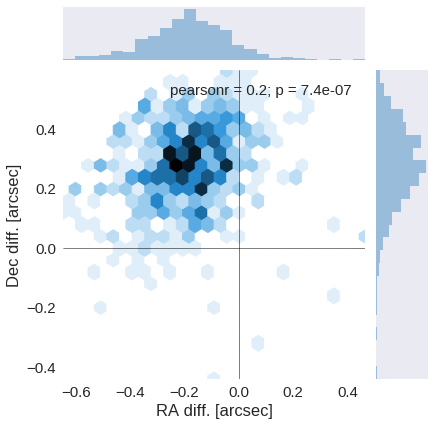

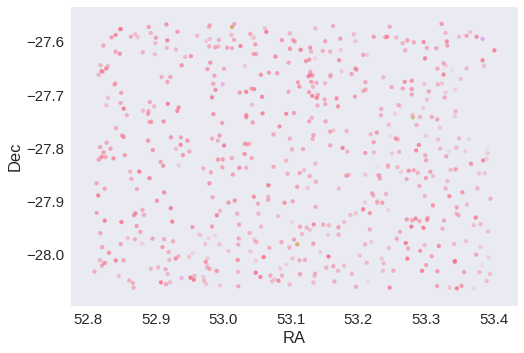

In [13]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [14]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.18399366377366277 arcsec
Dec correction: -0.283546868710971 arcsec


In [15]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

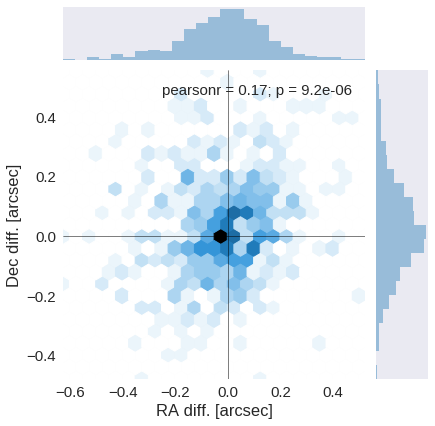

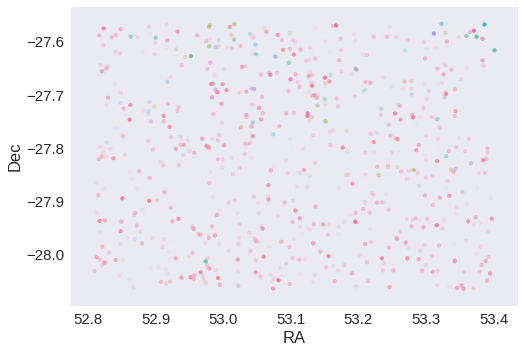

In [16]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [17]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [18]:
GAIA_FLAG_NAME = "combo_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

667 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [19]:
catalogue.write("{}/COMBO.fits".format(OUT_DIR), overwrite=True)